# Topic Modeling Using Sentence BERT

## Introduction

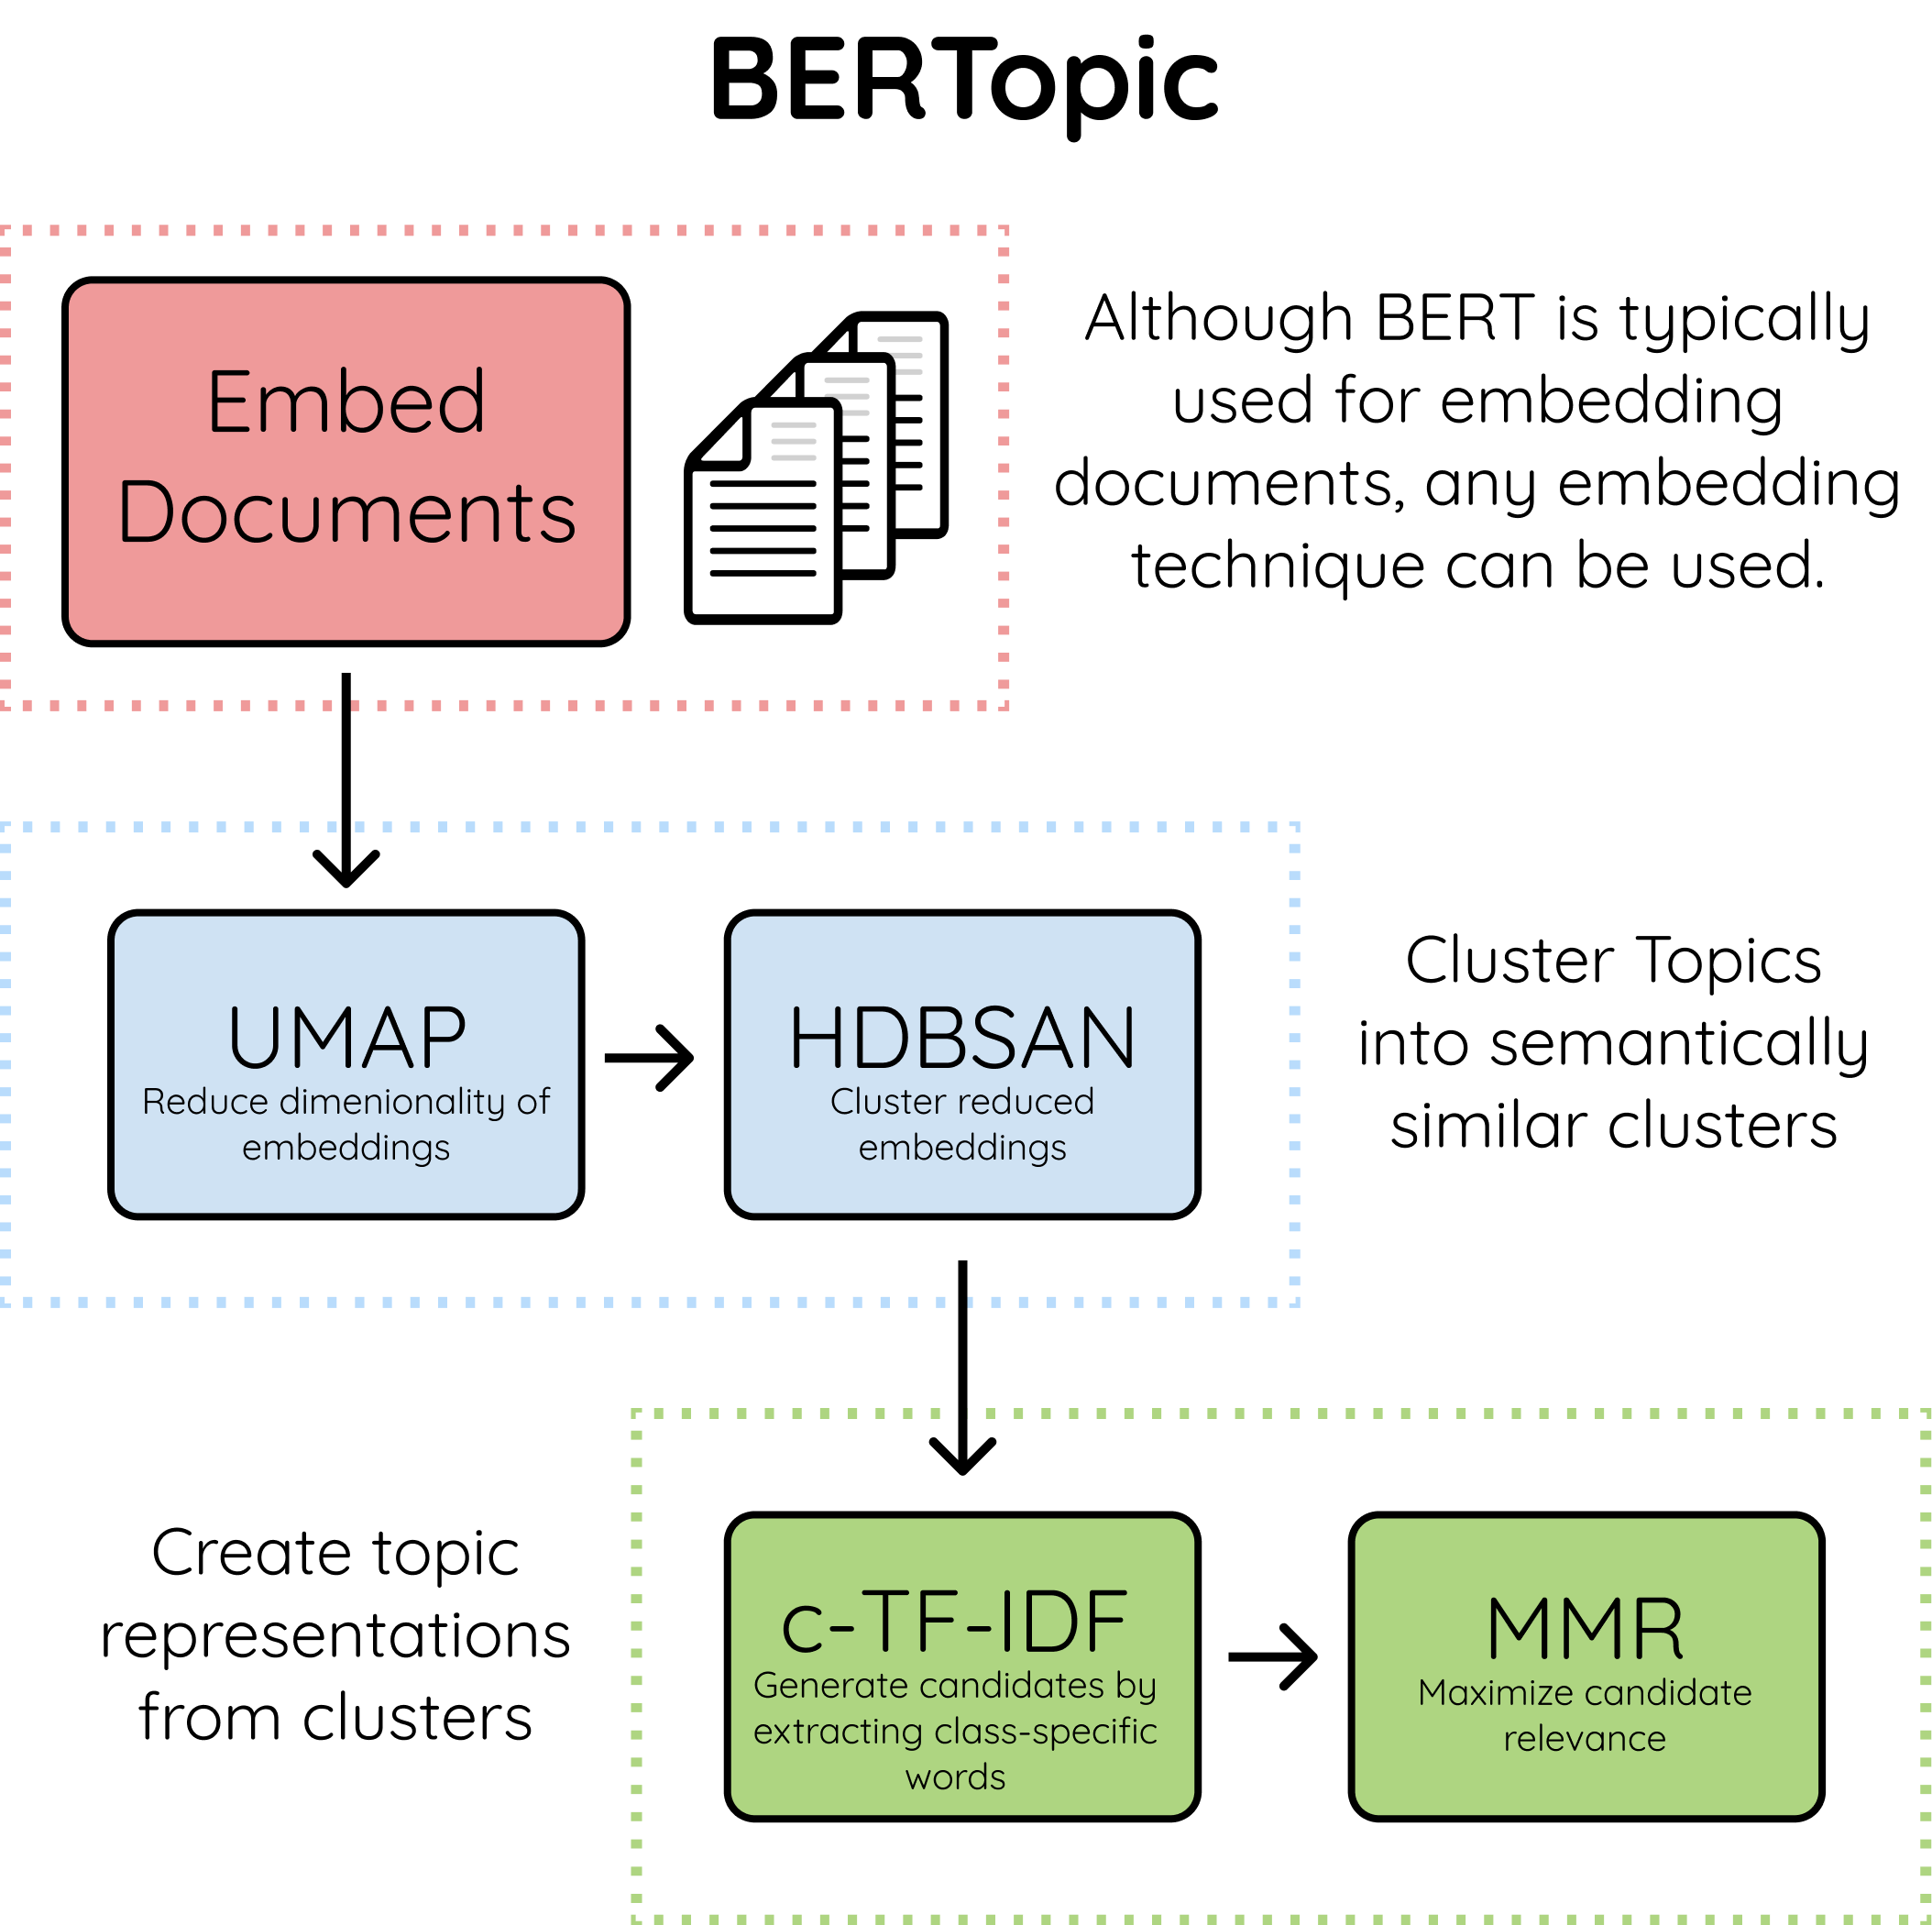

*We will extract topics using BERTopic, a library based on Sentence BERT.*

BERTopic is a BERT based topic modeling technique that leverages:
* Sentence Transformers, to obtain a robust semantic representation of the texts
* HDBSCAN, to create dense and relevant clusters
* Class-based TF-IDF (c-TF-IDF) to allow easy interpretable topics whilst keeping important words in the topics descriptions


For topics merging, BERTopic only proposes the following:

* At creation time, it automatically merges the topics with a (cosine) similarity above 0.915 (value hard-coded in the instantiation of the model object);
* At any time, it allows you to fix the number of topics to be created by specifying it explicitly via the appropriated parameter of the model. In that case, if the original number is higher than the parameter value specified, this will cause the former to be reduced iteratively by merging the least frequent topic with the most similar one until reaching this last.


## Install BERTopic

In [3]:
%%capture 
!pip install bertopic # Restart the notebook after installation

In [ ]:
!pip install --upgrade numba


## Data

In [1]:
# import libraries
import os
import pandas as pd
from bertopic import BERTopic
import gensim

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
data = pd.read_csv('Corrected_Final_All.csv', engine='python')
data.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,data_source,lang,score,langTb,lang_langdetect,preprocessed_data_without_hashtags
0,0,2021-03-27T04:09:42+00:00,1.380000e+18,1.380000e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['hacer', 'mayo', 'cazar', 'fantasma']"
1,1,2021-03-22T21:12:09+00:00,1.370000e+18,1.370000e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['despues', 'esperar', 'ancia', 'ahora', 'espe..."
2,2,2021-03-22T12:30:53+00:00,1.370000e+18,1.370000e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia..."
3,3,2021-04-04T12:56:55+00:00,1.380000e+18,1.380000e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['menos', 'mes', 'urkullu', 'temer', 'perder',..."
4,4,2021-04-03T20:14:57+00:00,1.380000e+18,1.380000e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['edicion', 'festival', 'internacional', 'puen..."


In [4]:

data['preprocessed_str_without_hashtags'] = data['preprocessed_data_without_hashtags'].apply(eval).apply(' '.join)
data.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,emoji_list,emoticons_list,filename,data_source,lang,score,langTb,lang_langdetect,preprocessed_data_without_hashtags,preprocessed_str_without_hashtags
0,0,2021-03-27T04:09:42+00:00,1.380000e+18,1.380000e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['hacer', 'mayo', 'cazar', 'fantasma']",hacer mayo cazar fantasma
1,1,2021-03-22T21:12:09+00:00,1.370000e+18,1.370000e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",despues esperar ancia ahora esperar despues se...
2,2,2021-03-22T12:30:53+00:00,1.370000e+18,1.370000e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",esperar llegar oido nuevo iniciar laboral part...
3,3,2021-04-04T12:56:55+00:00,1.380000e+18,1.380000e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['menos', 'mes', 'urkullu', 'temer', 'perder',...",menos mes urkullu temer perder control dar pas...
4,4,2021-04-03T20:14:57+00:00,1.380000e+18,1.380000e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['edicion', 'festival', 'internacional', 'puen...",edicion festival internacional puente hacia ce...


> * Data Pre-preprocessing

In [5]:
docs = data.preprocessed_str_without_hashtags.tolist()

# removes  punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

docs = list(sent_to_words(docs))

## Topic Modeling

> * Training

instatiating model, we set `language = multilingual` to select a model that supports multiple languages, since our dataset contains more than one language.  


In [26]:
reduced_model = BERTopic(language='multilingual', verbose=True, nr_topics=15, calculate_probabilities=True)
topics, probs = reduced_model.fit_transform(data.preprocessed_str_without_hashtags)

Batches: 100%|██████████| 693/693 [34:07<00:00,  2.96s/it]
2021-09-23 18:29:17,519 - BERTopic - Transformed documents to Embeddings
2021-09-23 18:29:48,523 - BERTopic - Reduced dimensionality with UMAP
2021-09-23 18:35:16,655 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-09-23 18:42:57,911 - BERTopic - Reduced number of topics from 386 to 16


> * Extracting Topics

In [37]:
reduced_model.get_topic_info()

,Topic,Count,Name
0,-1,8926,-1_mas_colombio_colombia_gobierno
1,0,1470,0_salud_mas_gobierno_nacional
2,1,1305,1_policia_corrupcion_corrupto_gobierno
3,2,1187,2_colombia_colombio_colombiano_venezuela
4,3,1052,3_indigena_querer_pueblo_estar
5,4,1043,4_martuchis_paraco_suppo_uribe
6,5,997,5_por_colombia_decir_historia
7,6,854,6_protester_violencia_violence_kill
8,7,743,7_gracias_amar_patria_amor
9,8,732,8_presidente_votar_dictadura_colombia


**Note:**  Topic -1 is the largest and it refers to outliers tweets that do not assign to any topics generated. In this case, we will ignore Topic -1.

**NOTE**: BERTopic is stocastich which mmeans that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

> * Visualization

In [27]:
# Visualizing the generated topics
reduced_model.visualize_topics()

In [30]:
reduced_model.visualize_barchart()

In [35]:
reduced_model.visualize_hierarchy()

In [36]:
reduced_model.visualize_term_rank()

In [34]:
reduced_model.visualize_heatmap()

In [53]:
similar_topics, similarity = reduced_model.find_topics("violence", top_n=5); similar_topics

[6, 9, 1, 13, 0]

> * Get topics and top words

In [40]:
topics_16 = reduced_model.get_topics()

In [54]:
pd.DataFrame(topics_16).T.to_csv('15-bertopic.csv', index=False)

In [51]:
pd.DataFrame(topics_16).T

,0,1,2,3,4,5,6,7,8,9
-1,"(mas, 0.018528338161866484)","(colombio, 0.016416819460225315)","(colombia, 0.01612545670635199)","(gobierno, 0.014184393233439231)","(colombiano, 0.01295380281624204)","(decir, 0.01272128372520626)","(dar, 0.010154406436293492)","(policia, 0.009661387681075046)","(dia, 0.009245217055156062)","(protesta, 0.00916362277458597)"
0,"(salud, 0.026115308846997073)","(mas, 0.021681498439210682)","(gobierno, 0.021507624001196903)","(nacional, 0.018887420375043425)","(justicia, 0.018076863948120688)","(libertad, 0.012489350065356846)","(alcalde, 0.012427101746180122)","(ministro, 0.012361691851765532)","(estar, 0.012023156650264483)","(educacion, 0.011482594987645648)"
1,"(policia, 0.03158947256660336)","(corrupcion, 0.029083043021455438)","(corrupto, 0.020471961637346922)","(gobierno, 0.01973995683346082)","(periodista, 0.01679802544453394)","(criminal, 0.016606894738725075)","(police, 0.012284396268563603)","(narcoestado, 0.011364893077958233)","(robar, 0.010618222753169189)","(impunidad, 0.009854087916349506)"
2,"(colombia, 0.03209050585749739)","(colombio, 0.03143435770946285)","(colombiano, 0.02433083144554721)","(venezuela, 0.01746326955167727)","(mexico, 0.01429508584114886)","(cuba, 0.013633355193979525)","(venezolano, 0.013441308309718819)","(venezuelo, 0.013337798841936392)","(cubano, 0.012779348299390045)","(chile, 0.011967686923674998)"
3,"(indigena, 0.03245160060462141)","(querer, 0.01721398065439557)","(pueblo, 0.014893712788299276)","(estar, 0.01450428685050515)","(acabar, 0.013667130115566438)","(salir, 0.012560611518670115)","(ser, 0.0124616248258787)","(hablar, 0.011866006072158023)","(matar, 0.01156847221236663)","(decir, 0.011147483908924396)"
4,"(martuchis, 0.04141683859050622)","(paraco, 0.04035315594927661)","(suppo, 0.03554473773297628)","(uribe, 0.03551685136565827)","(difundan, 0.029849181651037383)","(bolivar, 0.02954909317348171)","(espriella, 0.028225465536248266)","(paloma, 0.024939055511979683)","(esteban, 0.023246056126111504)","(amapola, 0.016534702940756582)"
5,"(por, 0.13397106004837755)","(colombia, 0.039721007202424836)","(decir, 0.0359736760877675)","(historia, 0.0334099292955399)","(paro, 0.0333913080504138)","(olvidar, 0.030373138620490243)","(mentir, 0.029637289903454534)","(si, 0.02571072705233388)","(hacer, 0.02345281706434863)","(verdad, 0.021162509210310407)"
6,"(protester, 0.03673686475909205)","(violencia, 0.03202669818947939)","(violence, 0.02628889045799128)","(kill, 0.02003323744129872)","(manifestante, 0.019623933249888335)","(colombian, 0.019475570587932083)","(colombia, 0.01845333231856361)","(protest, 0.017595333606960216)","(protestors, 0.014957379925335355)","(brutality, 0.011937768733095435)"
7,"(gracias, 0.0839482296133936)","(amar, 0.0322280133210915)","(patria, 0.02472343523172111)","(amor, 0.02457770880455805)","(colombiaprofesobjetalesobjeto, 0.022941746583...","(imparcial, 0.022771168353042843)","(noticiero, 0.022472239203765572)","(deleted, 0.021484455898294477)","(detener, 0.02122081905554426)","(desaparecido, 0.01904553198655242)"
8,"(presidente, 0.03751918426463651)","(votar, 0.027014577378767873)","(dictadura, 0.02536618043294919)","(colombia, 0.018581480459664745)","(democracy, 0.017435515906673627)","(president, 0.013905873884478429)","(politico, 0.013800943088386829)","(democracia, 0.013589213705963976)","(voto, 0.013385742798052002)","(colombio, 0.011631656327207246)"


In [55]:
# Save model
reduced_model.save('bertopic-15T')

# c-TF-IDF  
When you apply TF-IDF as usual on a set of documents, what you are doing is comparing the importance of words between documents. Now, what if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be importance scores for words within a cluster. The more important words are within a cluster, the more it is representative of that topic. In other words, if we extract the most important words per cluster, we get descriptions of topics! This model is called class-based TF-IDF

In [52]:
len(topics)

22160